# 03. 강화학습 트레이딩 환경 (Gym Environment)

**목표:** 에이전트가 학습할 수 있는 비트코인 트레이딩 환경 구현

```
[ 입력 ]  data/processed/train.csv, val.csv, test.csv
[ 출력 ]  BTCTradingEnv 클래스 (Gymnasium 호환)
```

**환경 설계 핵심**
```
Observation : 피처 벡터 + 현재 포지션 정보
Action      : 연속값 [-1, 1]  (-1=전량매도, 0=홀드, +1=전량매수)
Reward      : 리스크 조정 수익률 (Sharpe 기반)
```

## 1. 라이브러리 설치 및 Import

In [1]:
# 필요 시 설치
# !pip install gymnasium matplotlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
import warnings
warnings.filterwarnings('ignore')

print(f"numpy      : {np.__version__}")
print(f"gymnasium  : {gym.__version__}")

numpy      : 2.3.5
gymnasium  : 1.2.3


## 2. 데이터 로드

In [3]:
import os

PROCESSED_DIR = '../data/processed'

def load_data(name: str) -> pd.DataFrame:
    path = os.path.join(PROCESSED_DIR, f'{name}.csv')
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    return df

df_train = load_data('train')
df_val   = load_data('val')
df_test  = load_data('test')

print(f"Train : {len(df_train):,}행 x {len(df_train.columns)}열")
print(f"Val   : {len(df_val):,}행 x {len(df_val.columns)}열")
print(f"Test  : {len(df_test):,}행 x {len(df_test.columns)}열")
print(f"\n컬럼 목록: {list(df_train.columns)}")

Train : 47,836행 x 38열
Val   : 6,401행 x 38열
Test  : 16,380행 x 38열

컬럼 목록: ['close', 'volume', 'log_return_1', 'log_return_4', 'log_return_24', 'ema_9_ratio', 'ema_21_ratio', 'ema_50_ratio', 'ema_200_ratio', 'macd', 'macd_signal', 'macd_hist', 'adx', 'adx_pos', 'adx_neg', 'rsi_14', 'rsi_7', 'stoch_rsi_k', 'stoch_rsi_d', 'cci', 'williams_r', 'roc_9', 'roc_21', 'bb_width', 'bb_pct', 'atr_ratio', 'kc_pct', 'obv', 'volume_change', 'volume_ratio', 'mfi', 'candle_body', 'upper_wick', 'lower_wick', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']


## 3. 트레이딩 환경 클래스 구현

### 설계 원칙

**Observation (State)**
```
피처 벡터 (정규화된 기술적 지표들)
+ 현재 포지션 비율    (0~1)
+ 미실현 손익률       (-inf~inf)
+ 보유 기간           (정규화)
```

**Action**
```
연속값 [-1, 1]
  +0.1 이상  → 매수 신호 (값이 클수록 더 많이 매수)
  -0.1 이하  → 매도 신호 (값이 작을수록 더 많이 매도)
  -0.1~+0.1  → 홀드
```

**Reward**
```
= 로그 수익률
- 거래 비용 페널티
- 최대 낙폭 페널티
```

In [4]:
class BTCTradingEnv(gym.Env):
    """
    비트코인 트레이딩 Gymnasium 환경
    
    Parameters
    ----------
    df              : 피처가 포함된 DataFrame (close 컬럼 필수)
    initial_balance : 초기 자본 (USDT)
    fee_rate        : 거래 수수료율 (기본 0.05%)
    window_size     : 관측 윈도우 크기 (현재는 단일 스텝)
    max_position    : 최대 포지션 비율 (기본 1.0 = 전액)
    """
    
    metadata = {'render_modes': ['human']}
    
    def __init__(
        self,
        df: pd.DataFrame,
        initial_balance: float = 10_000.0,
        fee_rate: float = 0.0005,
        max_position: float = 1.0,
    ):
        super().__init__()
        
        self.df              = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.fee_rate        = fee_rate
        self.max_position    = max_position
        
        # close 컬럼 인덱스 확인
        assert 'close' in df.columns, "'close' 컬럼이 필요합니다."
        
        # 피처 컬럼 (close 제외)
        self.feature_cols = [c for c in df.columns if c != 'close']
        self.n_features   = len(self.feature_cols)
        
        # ─────────────────────────────────────────
        #  Action Space: 연속값 [-1, 1]
        # ─────────────────────────────────────────
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(1,), dtype=np.float32
        )
        
        # ─────────────────────────────────────────
        #  Observation Space
        #  피처 벡터 + [포지션비율, 미실현손익, 보유기간]
        # ─────────────────────────────────────────
        obs_dim = self.n_features + 3
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32
        )
        
        # 내부 상태 초기화
        self._reset_state()
        
        print(f"환경 초기화 완료")
        print(f"  데이터 길이   : {len(self.df):,}개")
        print(f"  피처 수       : {self.n_features}개")
        print(f"  Observation   : {obs_dim}차원")
        print(f"  Action        : 연속값 [-1, 1]")
        print(f"  초기 자본     : ${self.initial_balance:,.0f}")
        print(f"  수수료율      : {self.fee_rate*100:.3f}%")
    
    # ─────────────────────────────────────────────
    #  내부 상태 초기화
    # ─────────────────────────────────────────────
    def _reset_state(self):
        self.current_step    = 0
        self.balance         = self.initial_balance  # 보유 현금 (USDT)
        self.btc_held        = 0.0                   # 보유 BTC 수량
        self.position_ratio  = 0.0                   # 현재 포지션 비율 (0~1)
        self.avg_buy_price   = 0.0                   # 평균 매수 단가
        self.hold_steps      = 0                     # 현재 포지션 보유 기간
        self.total_fees      = 0.0                   # 누적 수수료
        self.trade_count     = 0                     # 거래 횟수
        
        # 성과 추적
        self.portfolio_values = [self.initial_balance]  # 포트폴리오 가치 이력
        self.peak_value       = self.initial_balance    # 최고점 (MDD 계산용)
        self.max_drawdown     = 0.0
        
        # 보상 계산용
        self.returns_history  = []  # 최근 수익률 이력 (Sharpe 계산용)
    
    # ─────────────────────────────────────────────
    #  현재 포트폴리오 총 가치
    # ─────────────────────────────────────────────
    def _get_portfolio_value(self, current_price: float) -> float:
        return self.balance + self.btc_held * current_price
    
    # ─────────────────────────────────────────────
    #  Observation 구성
    # ─────────────────────────────────────────────
    def _get_observation(self) -> np.ndarray:
        # 현재 스텝의 피처 벡터
        features = self.df.loc[self.current_step, self.feature_cols].values.astype(np.float32)
        
        current_price = self.df.loc[self.current_step, 'close']
        portfolio_val = self._get_portfolio_value(current_price)
        
        # 미실현 손익률
        if self.avg_buy_price > 0 and self.btc_held > 0:
            unrealized_pnl = (current_price - self.avg_buy_price) / self.avg_buy_price
        else:
            unrealized_pnl = 0.0
        
        # 포지션 정보 (3개)
        position_info = np.array([
            self.position_ratio,                    # 현재 포지션 비율 [0, 1]
            np.clip(unrealized_pnl, -1.0, 1.0),    # 미실현 손익률 (클리핑)
            np.clip(self.hold_steps / 100.0, 0, 1), # 보유 기간 (정규화)
        ], dtype=np.float32)
        
        obs = np.concatenate([features, position_info])
        
        # NaN/inf 방지
        obs = np.nan_to_num(obs, nan=0.0, posinf=1.0, neginf=-1.0)
        
        return obs
    
    # ─────────────────────────────────────────────
    #  거래 실행
    # ─────────────────────────────────────────────
    def _execute_trade(self, action: float, current_price: float):
        """
        action > +0.1 : 매수 (action 크기에 비례한 비율로)
        action < -0.1 : 매도
        else          : 홀드
        """
        portfolio_val  = self._get_portfolio_value(current_price)
        target_ratio   = np.clip((action + 1) / 2, 0, self.max_position)  # [-1,1] → [0,1]
        current_ratio  = (self.btc_held * current_price) / (portfolio_val + 1e-9)
        delta_ratio    = target_ratio - current_ratio
        
        fee = 0.0
        
        if delta_ratio > 0.01:  # 매수 (1% 이상 변화 시에만 거래)
            # 매수할 금액
            buy_amount = portfolio_val * delta_ratio
            buy_amount = min(buy_amount, self.balance)  # 보유 현금 초과 방지
            
            if buy_amount > 0:
                fee           = buy_amount * self.fee_rate
                btc_bought    = (buy_amount - fee) / current_price
                
                # 평균 매수가 업데이트
                total_btc     = self.btc_held + btc_bought
                if total_btc > 0:
                    self.avg_buy_price = (
                        self.avg_buy_price * self.btc_held + current_price * btc_bought
                    ) / total_btc
                
                self.btc_held  += btc_bought
                self.balance   -= buy_amount
                self.trade_count += 1
                self.hold_steps  = 0
        
        elif delta_ratio < -0.01:  # 매도
            # 매도할 BTC 수량
            sell_ratio = abs(delta_ratio) / (current_ratio + 1e-9)
            sell_ratio = min(sell_ratio, 1.0)
            btc_to_sell = self.btc_held * sell_ratio
            
            if btc_to_sell > 0:
                sell_amount   = btc_to_sell * current_price
                fee           = sell_amount * self.fee_rate
                self.balance += sell_amount - fee
                self.btc_held -= btc_to_sell
                
                if self.btc_held < 1e-8:  # 전량 매도
                    self.btc_held      = 0.0
                    self.avg_buy_price = 0.0
                    self.hold_steps    = 0
                
                self.trade_count += 1
        
        else:  # 홀드
            self.hold_steps += 1
        
        self.total_fees   += fee
        
        # 포지션 비율 업데이트
        new_portfolio_val = self._get_portfolio_value(current_price)
        self.position_ratio = (self.btc_held * current_price) / (new_portfolio_val + 1e-9)
    
    # ─────────────────────────────────────────────
    #  보상 함수
    # ─────────────────────────────────────────────
    def _compute_reward(self, prev_value: float, curr_value: float) -> float:
        """
        보상 = 로그 수익률 - MDD 페널티
        """
        # 로그 수익률
        log_return = np.log(curr_value / (prev_value + 1e-9))
        
        # MDD 업데이트 및 페널티
        if curr_value > self.peak_value:
            self.peak_value = curr_value
        
        drawdown = (self.peak_value - curr_value) / (self.peak_value + 1e-9)
        self.max_drawdown = max(self.max_drawdown, drawdown)
        
        # MDD가 20% 초과하면 강한 페널티
        drawdown_penalty = 0.0
        if drawdown > 0.20:
            drawdown_penalty = (drawdown - 0.20) * 2.0
        
        reward = log_return - drawdown_penalty
        
        # 수익률 이력 저장 (최근 24개 = 1일)
        self.returns_history.append(log_return)
        if len(self.returns_history) > 24:
            self.returns_history.pop(0)
        
        return float(reward)
    
    # ─────────────────────────────────────────────
    #  Reset
    # ─────────────────────────────────────────────
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._reset_state()
        obs = self._get_observation()
        info = {}
        return obs, info
    
    # ─────────────────────────────────────────────
    #  Step
    # ─────────────────────────────────────────────
    def step(self, action):
        action = float(np.clip(action, -1.0, 1.0))
        
        current_price = self.df.loc[self.current_step, 'close']
        prev_value    = self._get_portfolio_value(current_price)
        
        # 거래 실행
        self._execute_trade(action, current_price)
        
        # 다음 스텝으로 이동
        self.current_step += 1
        
        # 에피소드 종료 조건
        terminated = self.current_step >= len(self.df) - 1
        truncated  = False
        
        # 다음 스텝의 가격으로 포트폴리오 가치 계산
        next_price = self.df.loc[self.current_step, 'close']
        curr_value = self._get_portfolio_value(next_price)
        
        # 포트폴리오 가치 기록
        self.portfolio_values.append(curr_value)
        
        # 파산 조건 (초기 자본의 5% 이하)
        if curr_value < self.initial_balance * 0.05:
            terminated = True
        
        # 보상 계산
        reward = self._compute_reward(prev_value, curr_value)
        
        # Observation
        obs = self._get_observation()
        
        # Info (디버깅/로깅용)
        info = {
            'step'           : self.current_step,
            'portfolio_value': curr_value,
            'balance'        : self.balance,
            'btc_held'       : self.btc_held,
            'position_ratio' : self.position_ratio,
            'current_price'  : next_price,
            'total_return'   : (curr_value - self.initial_balance) / self.initial_balance,
            'max_drawdown'   : self.max_drawdown,
            'trade_count'    : self.trade_count,
            'total_fees'     : self.total_fees,
        }
        
        return obs, reward, terminated, truncated, info
    
    # ─────────────────────────────────────────────
    #  성과 시각화
    # ─────────────────────────────────────────────
    def render_performance(self, title: str = 'Trading Performance'):
        """에피소드 종료 후 성과 차트 출력"""
        portfolio_values = np.array(self.portfolio_values)
        
        # Buy & Hold 비교
        prices = self.df['close'].values[:len(portfolio_values)]
        bnh_values = self.initial_balance * (prices / prices[0])
        
        fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
        
        # 포트폴리오 가치
        axes[0].plot(portfolio_values, color='#627EEA', linewidth=1.2, label='RL Agent')
        axes[0].plot(bnh_values, color='#F7931A', linewidth=1.0, alpha=0.7, linestyle='--', label='Buy & Hold')
        axes[0].axhline(self.initial_balance, color='gray', linestyle=':', linewidth=0.8)
        axes[0].set_title(title, fontsize=13, fontweight='bold')
        axes[0].set_ylabel('Portfolio Value (USDT)')
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        
        # Drawdown
        rolling_max  = np.maximum.accumulate(portfolio_values)
        drawdown     = (rolling_max - portfolio_values) / (rolling_max + 1e-9)
        axes[1].fill_between(range(len(drawdown)), 0, -drawdown * 100, color='red', alpha=0.4)
        axes[1].set_ylabel('Drawdown (%)')
        axes[1].grid(alpha=0.3)
        
        # BTC 가격
        axes[2].plot(prices, color='#F7931A', linewidth=0.8)
        axes[2].set_ylabel('BTC Price (USDT)')
        axes[2].set_xlabel('Step (1H Candles)')
        axes[2].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 성과 지표 출력
        self._print_metrics(portfolio_values, bnh_values)
    
    def _print_metrics(self, portfolio_values, bnh_values):
        final_val   = portfolio_values[-1]
        total_ret   = (final_val - self.initial_balance) / self.initial_balance * 100
        bnh_ret     = (bnh_values[-1] - self.initial_balance) / self.initial_balance * 100
        
        returns     = np.diff(portfolio_values) / (portfolio_values[:-1] + 1e-9)
        sharpe      = (np.mean(returns) / (np.std(returns) + 1e-9)) * np.sqrt(24 * 365)
        
        rolling_max = np.maximum.accumulate(portfolio_values)
        drawdowns   = (rolling_max - portfolio_values) / (rolling_max + 1e-9)
        max_dd      = drawdowns.max() * 100
        
        win_trades  = sum(1 for r in returns if r > 0)
        win_rate    = win_trades / len(returns) * 100 if len(returns) > 0 else 0
        
        print("\n" + "=" * 45)
        print("  📊 성과 요약")
        print("=" * 45)
        print(f"  최종 자산        : ${final_val:>12,.2f}")
        print(f"  총 수익률        : {total_ret:>+10.2f}%")
        print(f"  Buy & Hold       : {bnh_ret:>+10.2f}%")
        print(f"  알파             : {total_ret - bnh_ret:>+10.2f}%p")
        print("-" * 45)
        print(f"  샤프 지수        : {sharpe:>10.3f}")
        print(f"  최대 낙폭 (MDD)  : {max_dd:>10.2f}%")
        print(f"  승률             : {win_rate:>10.2f}%")
        print("-" * 45)
        print(f"  총 거래 횟수     : {self.trade_count:>10,}회")
        print(f"  총 수수료        : ${self.total_fees:>11,.2f}")
        print("=" * 45)

print("BTCTradingEnv 클래스 정의 완료")

BTCTradingEnv 클래스 정의 완료


## 4. 환경 동작 테스트

### 4-1. 기본 초기화 및 스펙 확인

In [5]:
# 환경 생성
env = BTCTradingEnv(
    df=df_train,
    initial_balance=10_000.0,
    fee_rate=0.0005,
)

# 스펙 확인
print(f"\nObservation Space : {env.observation_space}")
print(f"Action Space      : {env.action_space}")

환경 초기화 완료
  데이터 길이   : 47,836개
  피처 수       : 37개
  Observation   : 40차원
  Action        : 연속값 [-1, 1]
  초기 자본     : $10,000
  수수료율      : 0.050%

Observation Space : Box(-inf, inf, (40,), float32)
Action Space      : Box(-1.0, 1.0, (1,), float32)


### 4-2. 랜덤 에이전트로 환경 테스트

에이전트를 붙이기 전에 랜덤 액션으로 환경이 정상 동작하는지 확인합니다.

In [6]:
# 랜덤 에이전트로 100 스텝 테스트
obs, info = env.reset(seed=42)

print(f"초기 Observation shape : {obs.shape}")
print(f"초기 Observation 샘플  : {obs[:5].round(4)}")
print()

total_reward = 0
for step in range(100):
    action = env.action_space.sample()       # 랜덤 액션
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    
    if step % 20 == 0:
        print(f"Step {step:3d} | Action: {action[0]:+.3f} | "
              f"Portfolio: ${info['portfolio_value']:>9,.2f} | "
              f"Position: {info['position_ratio']:.2f} | "
              f"Reward: {reward:+.6f}")
    
    if terminated or truncated:
        print("에피소드 종료")
        break

print(f"\n100 스텝 누적 보상: {total_reward:.6f}")
print("✅ 환경 정상 동작 확인")

초기 Observation shape : (40,)
초기 Observation 샘플  : [-0.6036  2.6339 -0.9242 -1.5891  0.214 ]

Step   0 | Action: +0.284 | Portfolio: $10,051.46 | Position: 0.64 | Reward: +0.005133
Step  20 | Action: +0.315 | Portfolio: $ 9,755.91 | Position: 0.66 | Reward: +0.012930
Step  40 | Action: -0.510 | Portfolio: $ 9,714.89 | Position: 0.25 | Reward: -0.005780
Step  60 | Action: -0.385 | Portfolio: $ 8,973.96 | Position: 0.31 | Reward: -0.000817
Step  80 | Action: -0.055 | Portfolio: $ 8,894.97 | Position: 0.47 | Reward: -0.001661

100 스텝 누적 보상: -0.086748
✅ 환경 정상 동작 확인


### 4-3. 전체 에피소드 랜덤 실행 및 성과 확인

환경 초기화 완료
  데이터 길이   : 6,401개
  피처 수       : 37개
  Observation   : 40차원
  Action        : 연속값 [-1, 1]
  초기 자본     : $10,000
  수수료율      : 0.050%
랜덤 에이전트 전체 에피소드 완료


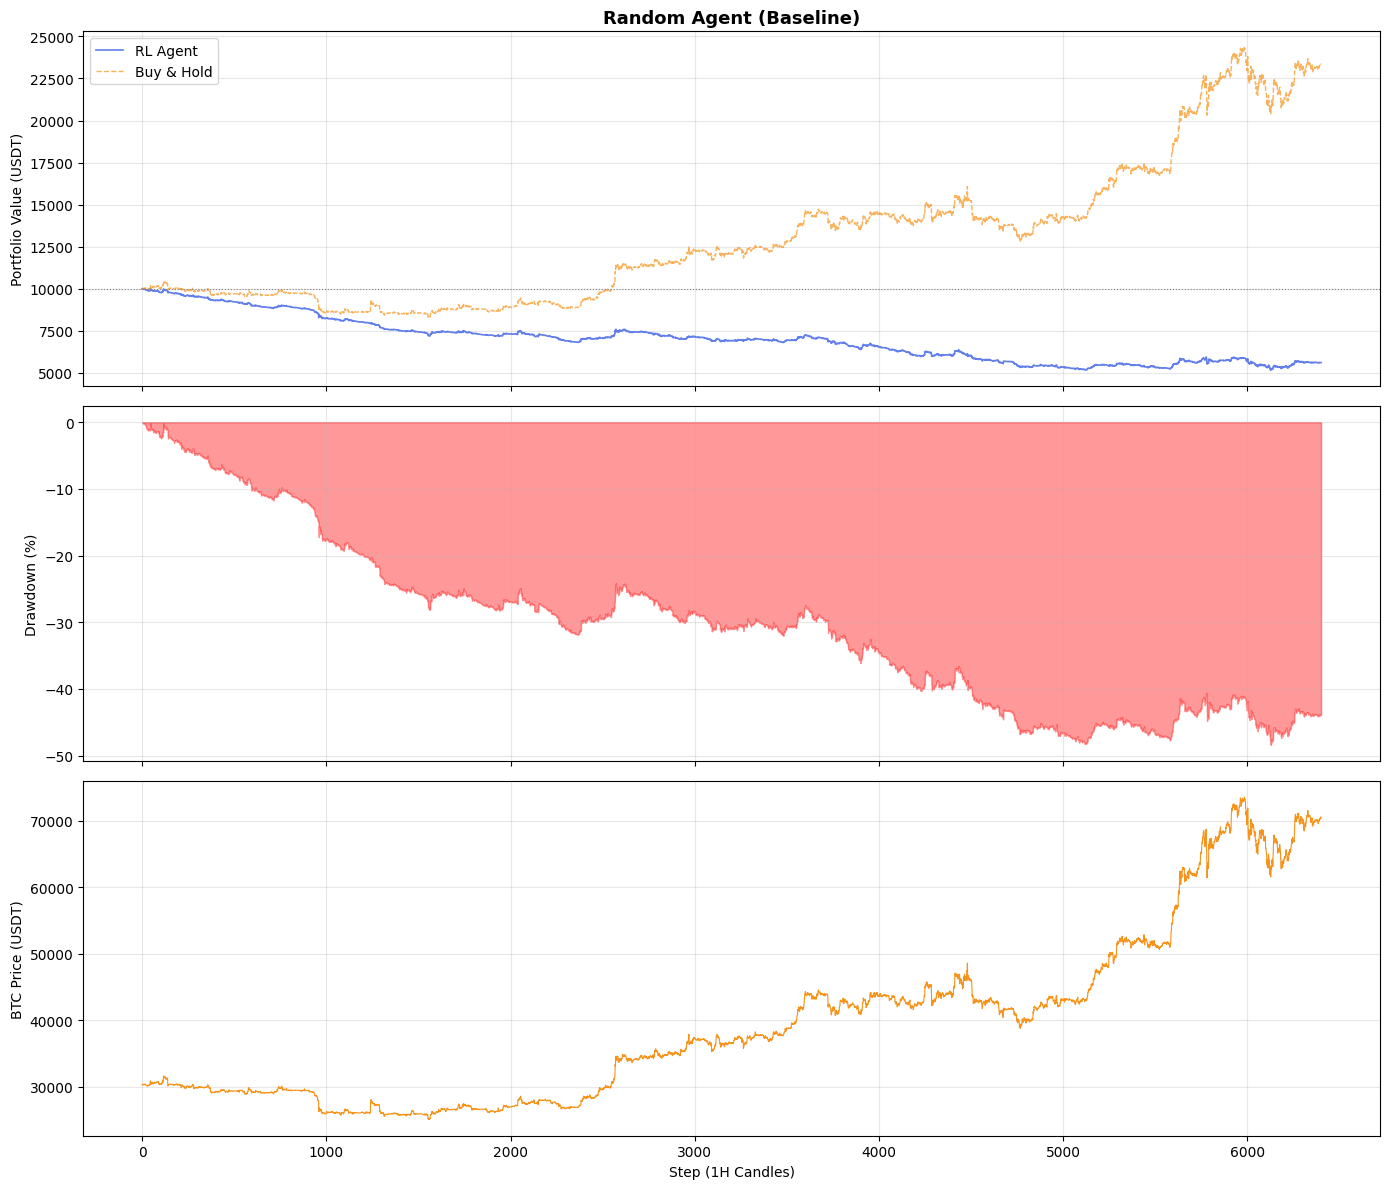


  📊 성과 요약
  최종 자산        : $    5,613.54
  총 수익률        :     -43.86%
  Buy & Hold       :    +133.37%
  알파             :    -177.24%p
---------------------------------------------
  샤프 지수        :     -2.924
  최대 낙폭 (MDD)  :      48.39%
  승률             :      42.31%
---------------------------------------------
  총 거래 횟수     :      6,271회
  총 수수료        : $   7,469.41


In [7]:
# 전체 에피소드를 랜덤 액션으로 실행
# (실제 학습 전 베이스라인 확인용)
env_test = BTCTradingEnv(df=df_val, initial_balance=10_000.0)
obs, _ = env_test.reset(seed=0)

done = False
while not done:
    action = env_test.action_space.sample()
    obs, reward, terminated, truncated, info = env_test.step(action)
    done = terminated or truncated

print("랜덤 에이전트 전체 에피소드 완료")
env_test.render_performance(title='Random Agent (Baseline)')

### 4-4. Gymnasium 표준 호환성 검사

In [8]:
from gymnasium.utils.env_checker import check_env

print("Gymnasium 호환성 검사 중...")
check_env_instance = BTCTradingEnv(df=df_train.head(500), initial_balance=10_000.0)
check_env(check_env_instance, warn=True)
print("✅ Gymnasium 호환성 검사 통과")

Gymnasium 호환성 검사 중...
환경 초기화 완료
  데이터 길이   : 500개
  피처 수       : 37개
  Observation   : 40차원
  Action        : 연속값 [-1, 1]
  초기 자본     : $10,000
  수수료율      : 0.050%
✅ Gymnasium 호환성 검사 통과


## 5. 환경 저장 (모듈화)

다음 노트북에서 바로 import해서 쓸 수 있도록 `src/` 폴더에 저장합니다.

In [9]:
# src/env/ 폴더 생성
import os
os.makedirs('../src/env', exist_ok=True)

env_code = '''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces


class BTCTradingEnv(gym.Env):
    """
    비트코인 트레이딩 Gymnasium 환경
    
    Parameters
    ----------
    df              : 피처가 포함된 DataFrame (close 컬럼 필수)
    initial_balance : 초기 자본 (USDT)
    fee_rate        : 거래 수수료율 (기본 0.05%)
    max_position    : 최대 포지션 비율 (기본 1.0)
    """
    
    metadata = {\'render_modes\': [\'human\']}
    
    def __init__(self, df, initial_balance=10_000.0, fee_rate=0.0005, max_position=1.0):
        super().__init__()
        self.df              = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.fee_rate        = fee_rate
        self.max_position    = max_position
        assert \'close\' in df.columns
        self.feature_cols    = [c for c in df.columns if c != \'close\']
        self.n_features      = len(self.feature_cols)
        self.action_space    = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        obs_dim              = self.n_features + 3
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self._reset_state()

    def _reset_state(self):
        self.current_step    = 0
        self.balance         = self.initial_balance
        self.btc_held        = 0.0
        self.position_ratio  = 0.0
        self.avg_buy_price   = 0.0
        self.hold_steps      = 0
        self.total_fees      = 0.0
        self.trade_count     = 0
        self.portfolio_values = [self.initial_balance]
        self.peak_value      = self.initial_balance
        self.max_drawdown    = 0.0
        self.returns_history = []

    def _get_portfolio_value(self, price):
        return self.balance + self.btc_held * price

    def _get_observation(self):
        features      = self.df.loc[self.current_step, self.feature_cols].values.astype(np.float32)
        current_price = self.df.loc[self.current_step, \'close\']
        unrealized_pnl = (
            (current_price - self.avg_buy_price) / self.avg_buy_price
            if self.avg_buy_price > 0 and self.btc_held > 0 else 0.0
        )
        position_info = np.array([
            self.position_ratio,
            np.clip(unrealized_pnl, -1.0, 1.0),
            np.clip(self.hold_steps / 100.0, 0, 1),
        ], dtype=np.float32)
        obs = np.concatenate([features, position_info])
        return np.nan_to_num(obs, nan=0.0, posinf=1.0, neginf=-1.0)

    def _execute_trade(self, action, current_price):
        portfolio_val = self._get_portfolio_value(current_price)
        target_ratio  = np.clip((action + 1) / 2, 0, self.max_position)
        current_ratio = (self.btc_held * current_price) / (portfolio_val + 1e-9)
        delta_ratio   = target_ratio - current_ratio
        fee = 0.0
        if delta_ratio > 0.01:
            buy_amount = min(portfolio_val * delta_ratio, self.balance)
            if buy_amount > 0:
                fee           = buy_amount * self.fee_rate
                btc_bought    = (buy_amount - fee) / current_price
                total_btc     = self.btc_held + btc_bought
                if total_btc > 0:
                    self.avg_buy_price = (self.avg_buy_price * self.btc_held + current_price * btc_bought) / total_btc
                self.btc_held    += btc_bought
                self.balance     -= buy_amount
                self.trade_count += 1
                self.hold_steps   = 0
        elif delta_ratio < -0.01:
            sell_ratio  = min(abs(delta_ratio) / (current_ratio + 1e-9), 1.0)
            btc_to_sell = self.btc_held * sell_ratio
            if btc_to_sell > 0:
                sell_amount   = btc_to_sell * current_price
                fee           = sell_amount * self.fee_rate
                self.balance += sell_amount - fee
                self.btc_held -= btc_to_sell
                if self.btc_held < 1e-8:
                    self.btc_held = 0.0; self.avg_buy_price = 0.0; self.hold_steps = 0
                self.trade_count += 1
        else:
            self.hold_steps += 1
        self.total_fees     += fee
        new_val              = self._get_portfolio_value(current_price)
        self.position_ratio  = (self.btc_held * current_price) / (new_val + 1e-9)

    def _compute_reward(self, prev_value, curr_value):
        log_return = np.log(curr_value / (prev_value + 1e-9))
        if curr_value > self.peak_value:
            self.peak_value = curr_value
        drawdown = (self.peak_value - curr_value) / (self.peak_value + 1e-9)
        self.max_drawdown = max(self.max_drawdown, drawdown)
        drawdown_penalty  = max(0, (drawdown - 0.20)) * 2.0
        self.returns_history.append(log_return)
        if len(self.returns_history) > 24:
            self.returns_history.pop(0)
        return float(log_return - drawdown_penalty)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self._reset_state()
        return self._get_observation(), {}

    def step(self, action):
        action        = float(np.clip(action, -1.0, 1.0))
        current_price = self.df.loc[self.current_step, \'close\']
        prev_value    = self._get_portfolio_value(current_price)
        self._execute_trade(action, current_price)
        self.current_step += 1
        terminated    = self.current_step >= len(self.df) - 1
        next_price    = self.df.loc[self.current_step, \'close\']
        curr_value    = self._get_portfolio_value(next_price)
        self.portfolio_values.append(curr_value)
        if curr_value < self.initial_balance * 0.05:
            terminated = True
        reward = self._compute_reward(prev_value, curr_value)
        info   = {
            \'step\': self.current_step, \'portfolio_value\': curr_value,
            \'balance\': self.balance, \'btc_held\': self.btc_held,
            \'position_ratio\': self.position_ratio, \'current_price\': next_price,
            \'total_return\': (curr_value - self.initial_balance) / self.initial_balance,
            \'max_drawdown\': self.max_drawdown, \'trade_count\': self.trade_count,
            \'total_fees\': self.total_fees,
        }
        return self._get_observation(), reward, terminated, False, info

    def render_performance(self, title=\'Trading Performance\'):
        portfolio_values = np.array(self.portfolio_values)
        prices     = self.df[\'close\'].values[:len(portfolio_values)]
        bnh_values = self.initial_balance * (prices / prices[0])
        fig, axes  = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
        axes[0].plot(portfolio_values, color=\'#627EEA\', linewidth=1.2, label=\'RL Agent\')
        axes[0].plot(bnh_values, color=\'#F7931A\', linewidth=1.0, alpha=0.7, linestyle=\'--\', label=\'Buy & Hold\')
        axes[0].set_title(title, fontsize=13, fontweight=\'bold\')
        axes[0].set_ylabel(\'Portfolio Value (USDT)\'); axes[0].legend(); axes[0].grid(alpha=0.3)
        rolling_max = np.maximum.accumulate(portfolio_values)
        drawdown    = (rolling_max - portfolio_values) / (rolling_max + 1e-9)
        axes[1].fill_between(range(len(drawdown)), 0, -drawdown * 100, color=\'red\', alpha=0.4)
        axes[1].set_ylabel(\'Drawdown (%)\'); axes[1].grid(alpha=0.3)
        axes[2].plot(prices, color=\'#F7931A\', linewidth=0.8)
        axes[2].set_ylabel(\'BTC Price\'); axes[2].set_xlabel(\'Step\'); axes[2].grid(alpha=0.3)
        plt.tight_layout(); plt.show()
        final_val = portfolio_values[-1]
        total_ret = (final_val - self.initial_balance) / self.initial_balance * 100
        bnh_ret   = (bnh_values[-1] - self.initial_balance) / self.initial_balance * 100
        returns   = np.diff(portfolio_values) / (portfolio_values[:-1] + 1e-9)
        sharpe    = (np.mean(returns) / (np.std(returns) + 1e-9)) * np.sqrt(24 * 365)
        rolling_max2 = np.maximum.accumulate(portfolio_values)
        max_dd    = ((rolling_max2 - portfolio_values) / (rolling_max2 + 1e-9)).max() * 100
        win_rate  = sum(1 for r in returns if r > 0) / len(returns) * 100 if len(returns) > 0 else 0
        print("\\n" + "="*45)
        print("  📊 성과 요약")
        print("="*45)
        print(f"  최종 자산        : ${final_val:>12,.2f}")
        print(f"  총 수익률        : {total_ret:>+10.2f}%")
        print(f"  Buy & Hold       : {bnh_ret:>+10.2f}%")
        print(f"  알파             : {total_ret - bnh_ret:>+10.2f}%p")
        print("-"*45)
        print(f"  샤프 지수        : {sharpe:>10.3f}")
        print(f"  최대 낙폭 (MDD)  : {max_dd:>10.2f}%")
        print(f"  승률             : {win_rate:>10.2f}%")
        print("-"*45)
        print(f"  총 거래 횟수     : {self.trade_count:>10,}회")
        print(f"  총 수수료        : ${self.total_fees:>11,.2f}")
        print("="*45)
'''

with open('../src/env/trading_env.py', 'w', encoding='utf-8') as f:
    f.write(env_code)

# __init__.py 생성
with open('../src/env/__init__.py', 'w') as f:
    f.write('from .trading_env import BTCTradingEnv\n')

with open('../src/__init__.py', 'w') as f:
    f.write('')

print("✅ 환경 모듈 저장 완료")
print("   → src/env/trading_env.py")
print("\n다음 노트북에서 아래처럼 import해서 사용:")
print("  import sys; sys.path.append('../src')")
print("  from env import BTCTradingEnv")

✅ 환경 모듈 저장 완료
   → src/env/trading_env.py

다음 노트북에서 아래처럼 import해서 사용:
  import sys; sys.path.append('../src')
  from env import BTCTradingEnv


---

## ✅ 완료 요약

| 항목 | 내용 | 상태 |
|---|---|---|
| Observation Space | 피처 벡터 + 포지션 정보 (n+3 차원) | ✅ |
| Action Space | 연속값 [-1, 1] | ✅ |
| 거래 실행 | 비율 기반 매수/매도, 수수료 반영 | ✅ |
| 보상 함수 | 로그 수익률 - MDD 페널티 | ✅ |
| 성과 시각화 | RL vs Buy&Hold 비교 차트 | ✅ |
| Gymnasium 호환성 | check_env 통과 | ✅ |
| 모듈 저장 | src/env/trading_env.py | ✅ |

**다음 단계:** `04_train_agent.ipynb` — PPO 에이전트 학습